## Visualisation

In [63]:
# Imports
import gc

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.synthid_text import synthid_mixin_remix as synthid_mixin
from src.synthid_text import logits_processing

import torch
import transformers

from hf_olmo import OLMoForCausalLM, OLMoTokenizerFast

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Device
DEVICE = (
    torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
)
DEVICE

In [ ]:
# Config
CONFIG = synthid_mixin.DEFAULT_WATERMARKING_CONFIG
CONFIG

In [ ]:
def load_model(
        model_name: str,
        expected_device: torch.device,
        enable_watermarking: bool
) -> transformers.PreTrainedModel:
    model_cls = (
        synthid_mixin.SynthIDGPT2LMHeadModel
        if enable_watermarking
        else transformers.GPT2LMHeadModel
    )
    model = model_cls.from_pretrained(model_name, device_map="auto")
        
    if str(model.device) != str(expected_device):
        raise ValueError('Model device is not as expected.')
    
    return model

In [ ]:
def generate_text(
        model_name: str,
        input_text: str,
        device: torch.device,
        enable_watermarking: bool,
):
    gc.collect()
    torch.cuda.empty_cache()
    
    tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"

    #logits_processor = logits_processing.SynthIDLogitsProcessor(
    #    **CONFIG, top_k=40, temperature=0.7
    #)
    
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding=True,
        return_token_type_ids=False
    ).to(device)
    
    model = load_model(
        model_name, expected_device=device, enable_watermarking=enable_watermarking
    )
    
    torch.manual_seed(0)
    outputs = model.generate(
        **inputs,
        do_sample=True,
        temperature=0.7,
        max_length=1024,
        top_k=40,
        pad_token_id=tokenizer.eos_token_id,
    )
    
    for output in outputs:
        print(tokenizer.decode(output, skip_special_tokens=True))
    
    del inputs, outputs, model
    gc.collect()
    torch.cuda.empty_cache()

In [ ]:
# Input text
input_text = ['I enjoy walking with my cute dog']

In [ ]:
generate_text(
    model_name='gpt2',
    input_text=input_text,
    device=DEVICE,
    enable_watermarking=True)

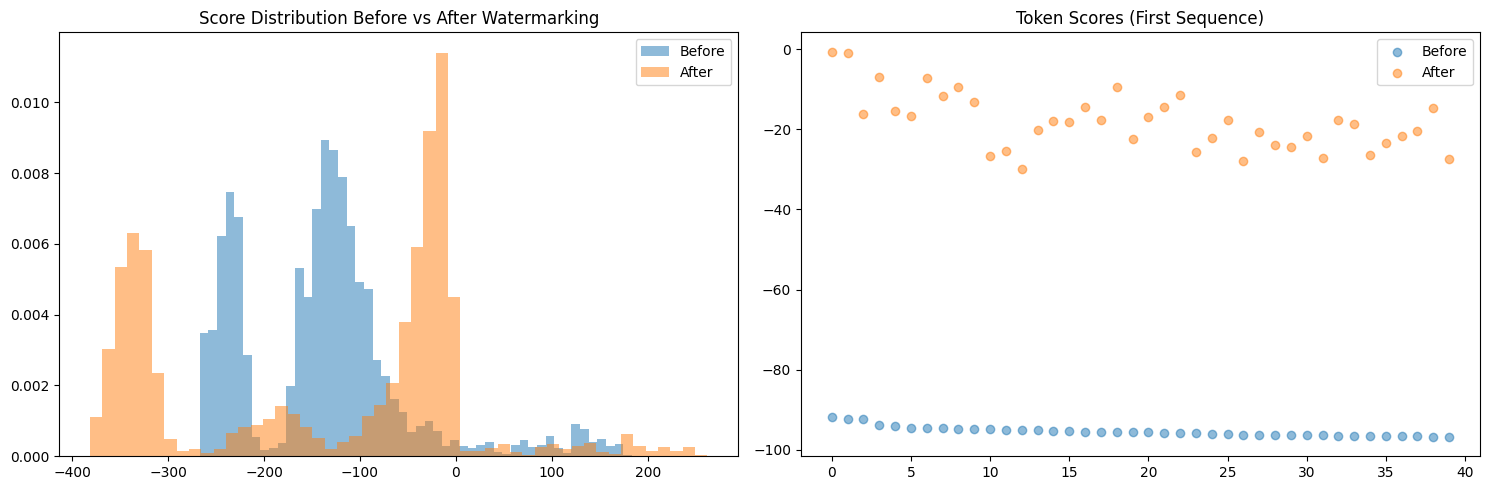

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def load_data(before_file, after_file, selected_file):
    before_data = []
    after_data = []
    selected_tokens = []
    
    with open(before_file) as f:
        for line in f:
            data = json.loads(line)
            before_data.append({
                'scores': data['next_token_scores'][0],
                'indices': data['token_indices'][0]
            })
    
    with open(after_file) as f:
        for line in f:
            data = json.loads(line)
            after_data.append(data['next_token_scores'][0])
            
    with open(selected_file) as f:
        for line in f:
            data = json.loads(line)
            selected_tokens.append(data['next_tokens'][0])
            
    return before_data, after_data, selected_tokens

def create_visualizations(before_data, after_data, selected_tokens):
    # Plot 1: Distribution comparison
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    
    # Remove extreme values (-999999995904.0)
    after_filtered = [[x for x in seq if x > -1000] for seq in after_data]
    
    plt.hist([x for seq in before_data for x in seq['scores']], 
             bins=50, alpha=0.5, label='Before', density=True)
    plt.hist([x for seq in after_filtered for x in seq], 
             bins=50, alpha=0.5, label='After', density=True)
    plt.title('Score Distribution Before vs After Watermarking')
    plt.legend()
    
    # Plot 2: Token filtering visualization
    plt.subplot(1, 2, 2)
    example_idx = 0
    plt.scatter(range(len(before_data[example_idx]['scores'])), 
               before_data[example_idx]['scores'], 
               alpha=0.5, label='Before')
    plt.scatter(range(len(after_data[example_idx])),
               after_data[example_idx],
               alpha=0.5, label='After')
    plt.title('Token Scores (First Sequence)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Execute visualization
before_data, after_data, selected_tokens = load_data(
    '../data/logits_before_watermarking.json',
    '../data/logits_after_watermarking.json', 
    '../data/selected_tokens.json'
)
create_visualizations(before_data, after_data, selected_tokens)

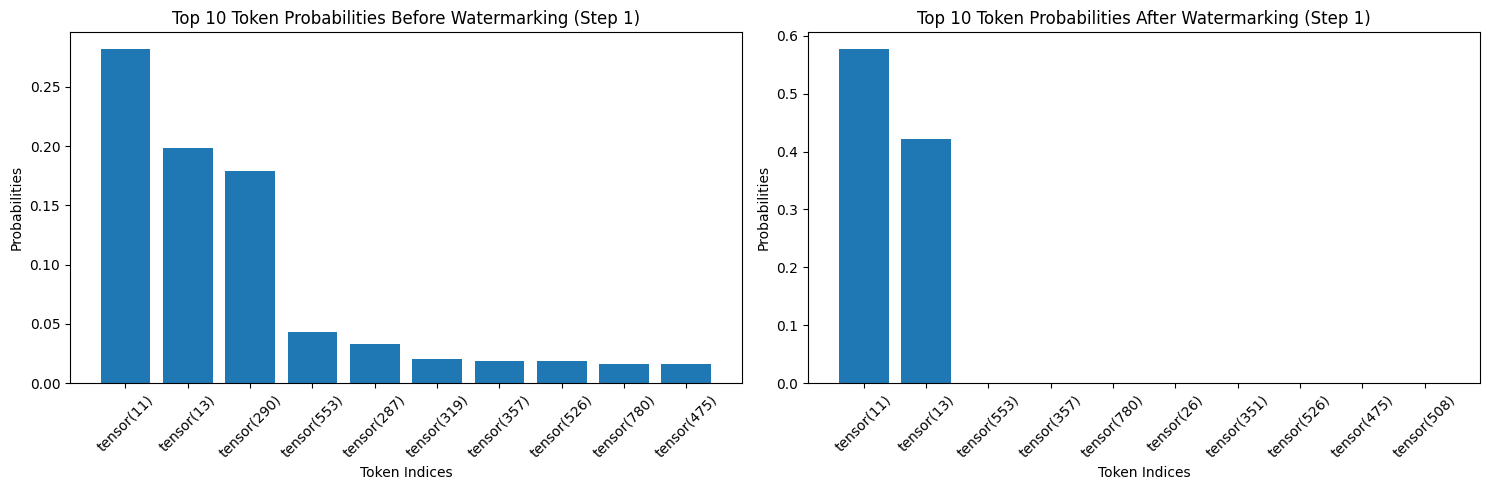

In [ ]:
import json
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def load_data(before_file, after_file, selected_file):
    before_data = []
    after_data = []
    selected_tokens = []
    
    with open(before_file) as f:
        for line in f:
            data = json.loads(line)
            before_data.append({
                'scores': data['next_token_scores'][0],
                'indices': data['token_indices'][0]
            })
    
    with open(after_file) as f:
        for line in f:
            data = json.loads(line)
            after_data.append({
                'scores': data['next_token_scores'][0],
                'indices': data['next_token_indices'][0]})
            
    with open(selected_file) as f:
        for line in f:
            data = json.loads(line)
            selected_tokens.append(data['next_tokens'][0])
            
    return before_data, after_data, selected_tokens

def plot_top_tokens(before_data, after_data, step):
    before_logits = torch.tensor(before_data[step]['scores'])
    before_logits_indices = torch.tensor(before_data[step]['indices'])

    after_logits = torch.tensor(after_data[step]['scores'])
    after_logits_indices = torch.tensor(after_data[step]['indices'])
    
    # Convert logits to probabilities
    before_probs = F.softmax(before_logits, dim=-1)
    after_probs = F.softmax(after_logits, dim=-1)
    
    # Sort probabilities
    sorted_before_probs, sorted_before_indices = torch.sort(before_probs, descending=True)
    sorted_after_probs, sorted_after_indices = torch.sort(after_probs, descending=True)

    global_before_indices = [before_logits_indices[i] for i in sorted_before_indices]
    global_after_indices = [after_logits_indices[i] for i in sorted_after_indices]
    
    # Get the top 10 tokens and their probabilities
    top_before_probs = sorted_before_probs[:10].cpu().numpy()
    top_after_probs = sorted_after_probs[:10].cpu().numpy()
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(10), top_before_probs)
    plt.xticks(range(10), global_before_indices[:10], rotation=45)
    plt.title(f"Top 10 Token Probabilities Before Watermarking (Step {step + 1})")
    plt.xlabel("Token Indices")
    plt.ylabel("Probabilities")
    
    plt.subplot(1, 2, 2)
    plt.bar(range(10), top_after_probs)
    plt.xticks(range(10), global_after_indices[:10], rotation=45)
    plt.title(f"Top 10 Token Probabilities After Watermarking (Step {step + 1})")
    plt.xlabel("Token Indices")
    plt.ylabel("Probabilities")
    
    plt.tight_layout()
    plt.show()

# Execute visualization
before_data, after_data, selected_tokens = load_data(
    '../data/logits_before_watermarking.json',
    '../data/logits_after_watermarking.json', 
    '../data/selected_tokens.json'
)

# Plot for a specific step
plot_top_tokens(before_data, after_data, step=0)

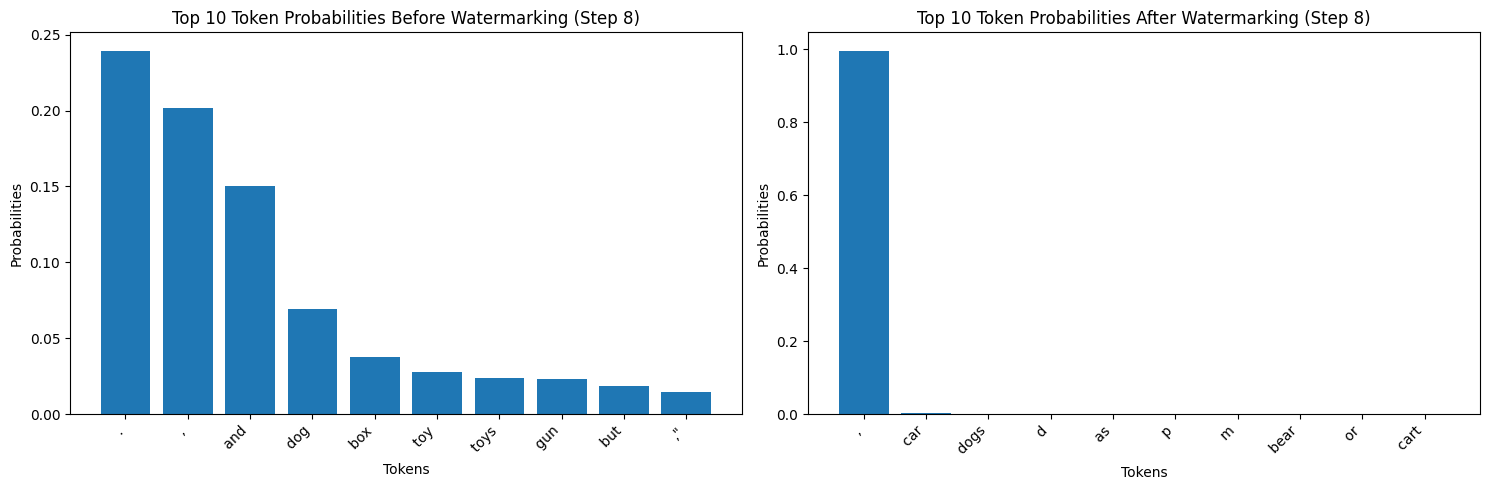

In [ ]:
import json
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer

def load_data(before_file, after_file, selected_file):
    before_data = []
    after_data = []
    selected_tokens = []
    
    with open(before_file) as f:
        for line in f:
            data = json.loads(line)
            before_data.append({
                'scores': data['next_token_scores'][0],
                'indices': data['token_indices'][0]
            })
    
    with open(after_file) as f:
        for line in f:
            data = json.loads(line)
            after_data.append({
                'scores': data['next_token_scores'][0],
                'indices': data['next_token_indices'][0]})
            
    with open(selected_file) as f:
        for line in f:
            data = json.loads(line)
            selected_tokens.append(data['next_tokens'][0])
            
    return before_data, after_data, selected_tokens

def plot_top_tokens(before_data, after_data, step, tokenizer):
    before_logits = torch.tensor(before_data[step]['scores'])
    before_logits_indices = torch.tensor(before_data[step]['indices'])

    after_logits = torch.tensor(after_data[step]['scores'])
    after_logits_indices = torch.tensor(after_data[step]['indices'])
    
    # Convert logits to probabilities
    before_probs = F.softmax(before_logits, dim=-1)
    after_probs = F.softmax(after_logits, dim=-1)
    
    # Sort probabilities
    sorted_before_probs, sorted_before_indices = torch.sort(before_probs, descending=True)
    sorted_after_probs, sorted_after_indices = torch.sort(after_probs, descending=True)

    global_before_indices = [before_logits_indices[i] for i in sorted_before_indices]
    global_after_indices = [after_logits_indices[i] for i in sorted_after_indices]
    
    
    # Get the top 10 tokens and their probabilities
    top_before_probs = sorted_before_probs[:10].cpu().numpy()
    top_after_probs = sorted_after_probs[:10].cpu().numpy()
    
    top_before_tokens = [tokenizer.decode([idx.item()]) for idx in global_before_indices[:10]]
    top_after_tokens = [tokenizer.decode([idx.item()]) for idx in global_after_indices[:10]]
    
    # Plotting
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(10), top_before_probs)
    plt.xticks(range(10), top_before_tokens, rotation=45, ha='right')
    plt.title(f"Top 10 Token Probabilities Before Watermarking (Step {step + 1})")
    plt.xlabel("Tokens")
    plt.ylabel("Probabilities")
    
    plt.subplot(1, 2, 2)
    plt.bar(range(10), top_after_probs)
    plt.xticks(range(10), top_after_tokens, rotation=45, ha='right')
    plt.title(f"Top 10 Token Probabilities After Watermarking (Step {step + 1})")
    plt.xlabel("Tokens")
    plt.ylabel("Probabilities")
    
    plt.tight_layout()
    plt.show()

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Execute visualization
before_data, after_data, selected_tokens = load_data(
    '../data/logits_before_watermarking.json',
    '../data/logits_after_watermarking.json', 
    '../data/selected_tokens.json'
)

# Plot for a specific step
plot_top_tokens(before_data, after_data, step=7, tokenizer=tokenizer)


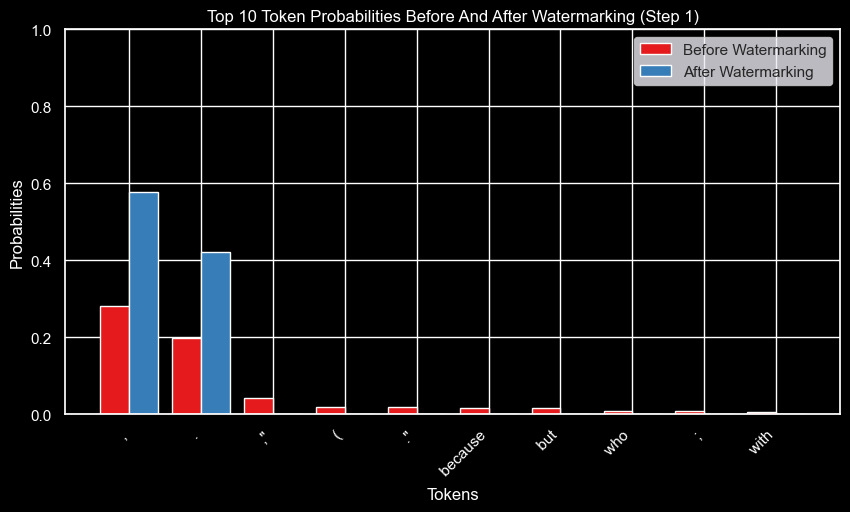

In [61]:
import json
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from transformers import GPT2Tokenizer
import seaborn as sns
from matplotlib.animation import FuncAnimation, PillowWriter

def load_data(before_file, after_file, selected_file):
    before_data = []
    after_data = []
    selected_tokens = []
    
    with open(before_file) as f:
        for line in f:
            data = json.loads(line)
            before_data.append({
                'scores': data['next_token_scores'][0],
                'indices': data['token_indices'][0]
            })
    
    with open(after_file) as f:
        for line in f:
            data = json.loads(line)
            after_data.append({
                'scores': data['next_token_scores'][0],
                'indices': data['next_token_indices'][0]})
            
    with open(selected_file) as f:
        for line in f:
            data = json.loads(line)
            selected_tokens.append(data['next_tokens'][0])
            
    return before_data, after_data, selected_tokens

def plot_top_tokens(before_data, after_data, step, tokenizer,ax):

    before_logits = torch.tensor(before_data[step]['scores'])
    before_logits_indices = torch.tensor(before_data[step]['indices'])

    after_logits = torch.tensor(after_data[step]['scores'])
    after_logits_indices = torch.tensor(after_data[step]['indices'])
    
    # Convert logits to probabilities
    before_probs = F.softmax(before_logits, dim=-1)
    after_probs = F.softmax(after_logits, dim=-1)
    
    # Sort probabilities
    sorted_before_probs, sorted_before_indices = torch.sort(before_probs, descending=True)
    sorted_after_probs, sorted_after_indices = torch.sort(after_probs, descending=True)

    
    global_after_indices = [after_logits_indices[i] for i in sorted_after_indices]
    global_before_indices = global_after_indices

    
    
    # Get the top 10 tokens and their probabilities

    top_before_probs_indices = [before_logits_indices.tolist().index(idx) for idx in global_after_indices[:10]]

    top_before_probs = [before_probs[i] for i in top_before_probs_indices[:10]]
    top_after_probs = sorted_after_probs[:10].cpu().numpy()
    
    
    top_after_tokens = [tokenizer.decode([idx.item()]) for idx in global_after_indices[:10]]
    top_before_tokens = [tokenizer.decode([idx.item()]) for idx in global_before_indices[:10]]

    top_before = [(top_before_probs[i].item(), top_before_tokens[i]) for i in range(10)]
    top_after = [(top_after_probs[i], top_after_tokens[i]) for i in range(10)]

    top_before.sort(key=lambda x: x[0], reverse=True)
    
    ax.clear()
    # Plotting
    x = range(10)
    width = 0.4  # the width of the bars
    #fig, ax = plt.subplots(figsize=(15, 5), facecolor='black')
    
    #ax.set_facecolor('black')
    palette = sns.color_palette("Set1", 2)
    
    ax.bar(x, [top_before[i][0] for i in range(10)], width=width, label='Before Watermarking', color=palette[0])
    ax.bar([p + width for p in x], [top_after[i][0] for i in range(10)], width=width, label='After Watermarking', color=palette[1])
    
    ax.set_xticks([p + width/2 for p in x])
    ax.set_xticklabels([top_before[i][1] for i in range(10)], rotation=45, ha='right')

    ax.set_title(f"Top 10 Token Probabilities Before And After Watermarking (Step {step + 1})", color='white')
    ax.set_xlabel("Tokens",color='white')
    ax.set_ylabel("Probabilities", color='white')
    ax.legend()

    ax.set_ylim(0, 1)

    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    
def animate(step):
    plot_top_tokens(before_data, after_data, step, tokenizer, ax)

sns.set_theme(style='darkgrid')

# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Execute visualization
before_data, after_data, selected_tokens = load_data(
    '../data/ogits_before_watermarking.json',
    '../data/logits_after_watermarking.json', 
    '../data/selected_tokens.json'
)

fig, ax = plt.subplots(figsize=(10, 5), facecolor='black')
ax.set_facecolor('black')

# Create the animation
ani = FuncAnimation(fig, animate, frames=range(51), interval=500)

# Save or display the animation
ani.save('../data/token_probabilities_animation.gif', writer=PillowWriter(fps=1))

# plt.show()  # Uncomment this line to display the animation in a window
